In [322]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split


In [323]:
#Limpieza del dataset como en TP1

oportunidades = pd.read_csv("Train_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades = oportunidades.dropna()
oportunidades

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,2015-04-21,...,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None
5,16802,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,Q1,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None
7,27455,Americas,NW America,1,1,1,1,0,Bureaucratic_Code_4,2015-04-21,...,Q1,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None
23,28524,APAC,India,1,1,1,1,0,Bureaucratic_Code_4,2015-10-13,...,Q1,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,18519,APAC,Japan,1,1,1,1,0,Bureaucratic_Code_4,2013-07-28,...,Q1,2016,NaT,0,USD,13200.0,USD,6422400.6,Closed Won,Prod_Category_A_None
16923,27689,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,Q1,2016,NaT,0,JPY,12194000.0,JPY,12194000.0,Closed Won,Prod_Category_A_None
16924,27688,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,Q1,2016,NaT,0,JPY,11959500.0,JPY,11959500.0,Closed Won,Prod_Category_A_None
16925,19062,APAC,Japan,0,0,0,0,0,Bureaucratic_Code_4,2013-08-11,...,Q1,2016,NaT,0,JPY,17537000.0,JPY,17537000.0,Closed Won,Prod_Category_A_None


In [324]:
#Añadimos la columna binaria de si es aprobada o no.

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})
oportunidades.head()

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
2,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
4,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None
5,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,Q1,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None
7,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,Q1,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None
23,28524,APAC,India,1,Bureaucratic_Code_4,2015-10-13,None,India,Account_Name_1147,Opportunity_Name_7036,...,Q1,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None


In [325]:
#Encoding de los vendedores con mean encoding respecto del total amount.
encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Encoding_Vendedor
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,2.232794e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,2.232794e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,2.232794e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,2.232794e+06
4,21750,Americas,NE America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1814,...,2017,NaT,0,USD,11961.6,USD,0.0,Closed Won,Prod_Category_A_None,2.232794e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,28141,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4988,...,2018,NaT,1,JPY,38976000.0,JPY,38976000.0,Closed Lost,Prod_Category_A_None,5.688996e+07
9721,28084,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4989,...,2018,NaT,1,JPY,56028000.0,JPY,56028000.0,Closed Lost,Prod_Category_A_None,5.688996e+07
9722,28181,APAC,Japan,1,Bureaucratic_Code_1,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4994,...,2018,NaT,0,JPY,7660800.0,JPY,7660800.0,Closed Lost,Prod_Category_A_None,5.688996e+07
9723,28182,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_8661,...,2019,NaT,0,JPY,825000.0,JPY,825000.0,Closed Won,Prod_Category_A_None,5.688996e+07


In [326]:
#Encoding de los territorios en base al total amount
encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Encoding_Vendedor,Encoding_Territorio
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,NaT,0,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,NaT,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04
9721,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,NaT,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04
9722,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,NaT,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04
9723,14879,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,NaT,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04


In [327]:
#Encoding de las regiones en base a Dummies

#encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
#encoding_region.columns = ['Encoding_Region']
#encoding_region = encoding_region.reset_index()
#oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')
oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Region'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Encoding_Vendedor,Encoding_Territorio,APAC,Americas,EMEA
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,0,1,0
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06,0,1,0
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06,0,1,0
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,0,1,0
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04,1,0,0
9721,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04,1,0,0
9722,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04,1,0,0
9723,14879,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04,1,0,0


In [328]:
#Encoding del tipo de moneda en base al mean del ASP
encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'ASP' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Encoding_Vendedor,Encoding_Territorio,APAC,Americas,EMEA,Encoding_Moneda
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,USD,83865.6,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,0,1,0,0.421977
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,USD,13357192.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06,0,1,0,0.421977
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,USD,14838277.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06,0,1,0,0.421977
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,USD,50688.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,0,1,0,0.421977
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,USD,2814.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,0,1,0,0.421977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,AUD,117600.0,Closed Won,Prod_Category_A_None,8.658390e+04,1.042592e+06,1,0,0,0.547969
9721,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,AUD,117600.0,Closed Won,Prod_Category_A_None,8.658390e+04,1.042592e+06,1,0,0,0.547969
9722,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,AUD,117600.0,Closed Won,Prod_Category_A_None,8.658390e+04,1.042592e+06,1,0,0,0.547969
9723,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,USD,0.0,Closed Lost,Prod_Category_A_None,8.658390e+04,1.042592e+06,1,0,0,0.547969


In [329]:
#Encoding del Bureaucratic_Code en base a Dummies
oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])], axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Americas,EMEA,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1,0,0.421977,0,0,0,0,1,0,0
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1,0,0.421977,0,0,0,0,0,1,0
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1,0,0.421977,0,0,0,0,0,1,0
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,1,0,0.421977,0,0,0,0,1,0,0
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,1,0,0.421977,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,0,0,0.547969,0,0,0,0,1,0,0
9721,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,0,0,0.547969,0,0,0,0,1,0,0
9722,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,0,0,0.547969,0,0,0,0,1,0,0
9723,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,0,0,0.547969,0,0,0,0,1,0,0


In [330]:
#Encoding del Billing Country en base a mean de Total_Amount.
encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,EMEA,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0.421977,0,0,0,0,1,0,0,2.245889e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,0,0.421977,0,0,0,0,0,1,0,2.245889e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,0,0.421977,0,0,0,0,0,1,0,2.245889e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,0.421977,0,0,0,0,1,0,0,2.245889e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,0,0.421977,0,0,0,0,1,0,0,2.245889e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,6773,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9426,...,1,0.376488,0,0,0,0,1,0,0,4.164458e+06
9721,6779,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9496,...,1,0.376488,0,0,0,0,1,0,0,4.164458e+06
9722,6790,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4195,...,1,0.376488,0,0,0,0,1,0,0,4.164458e+06
9723,6762,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4194,...,1,0.376488,0,0,0,0,1,0,0,4.164458e+06


In [331]:
#Encoding del Product_Family en base a mean de Total_Amount.
encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0.421977,0,0,0,0,1,0,0,2.245889e+06,69490.525
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0.421977,0,0,0,0,1,0,0,2.245889e+06,69490.525
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0.376488,0,0,0,0,1,0,0,8.585832e+05,69490.525
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0.376488,0,0,0,0,1,0,0,1.240120e+06,69490.525
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0.421977,0,0,0,0,0,1,0,9.806871e+05,69490.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0.421977,0,0,0,0,1,0,0,1.079523e+05,2197.250
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0.421977,0,0,0,0,1,0,0,1.079523e+05,369.600
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0.421977,0,0,0,0,1,0,0,1.079523e+05,2274.300
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0.421977,0,0,0,0,1,0,0,1.079523e+05,3456.000


In [332]:
#Encoding con Dummies de Account_Type

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Account_Type_6,None
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,2.245889e+06,69490.525,0,0,0,0,1,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,2.245889e+06,69490.525,0,0,0,0,1,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,8.585832e+05,69490.525,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,1.240120e+06,69490.525,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,9.806871e+05,69490.525,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,1.079523e+05,2197.250,1,0,0,0,0,0,0
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,1.079523e+05,369.600,1,0,0,0,0,0,0
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,1.079523e+05,2274.300,1,0,0,0,0,0,0
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,1.079523e+05,3456.000,1,0,0,0,0,0,0


In [333]:
#Encoding del Account Name en base al mean del Total_Amount debido a que son muchos nunique

encoding_account_name = oportunidades.groupby('Account_Name').agg({'Total_Amount' : 'mean'})
encoding_account_name.columns = ['Encoding_Acc_Name']
encoding_account_name = encoding_account_name.reset_index()
oportunidades = oportunidades.merge(encoding_account_name, how='inner', on='Account_Name')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Billing_Country,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Account_Type_6,None,Encoding_Acc_Name
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2.245889e+06,6.949052e+04,0,0,0,0,1,0,0,9.817534e+04
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,2.245889e+06,6.949052e+04,0,0,0,0,1,0,0,9.817534e+04
2,27447,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8261,...,2.245889e+06,5.458499e+06,0,0,0,0,1,0,0,9.817534e+04
3,27445,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8269,...,2.245889e+06,5.458499e+06,0,0,0,0,1,0,0,9.817534e+04
4,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2.245889e+06,8.134059e+04,0,0,0,0,1,0,0,9.817534e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,18523,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8875,...,4.557915e+05,2.562926e+06,0,0,1,0,0,0,0,1.928736e+06
9721,18513,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8874,...,4.557915e+05,2.562926e+06,0,0,1,0,0,0,0,1.928736e+06
9722,18519,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8874,...,4.557915e+05,7.050000e+03,0,0,1,0,0,0,0,1.928736e+06
9723,18516,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8874,...,4.557915e+05,1.346400e+04,0,0,1,0,0,0,0,1.928736e+06


In [334]:
#Encoding de Delivery Terms en base a Dummies
oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Acc_Name,Delivery_Terms_0,Delivery_Terms_1,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,9.817534e+04,0,0,0,0,1,0,0,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,9.817534e+04,0,0,0,0,1,0,0,0,0
2,27447,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8261,...,9.817534e+04,0,0,0,0,0,0,0,0,1
3,27445,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8269,...,9.817534e+04,0,0,0,0,0,0,0,0,1
4,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,9.817534e+04,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,18523,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8875,...,1.928736e+06,0,0,0,0,0,0,1,0,0
9721,18513,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8874,...,1.928736e+06,0,0,0,0,0,0,1,0,0
9722,18519,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8874,...,1.928736e+06,0,0,0,0,0,0,1,0,0
9723,18516,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8874,...,1.928736e+06,0,0,0,0,0,0,1,0,0


In [335]:
#Obtenemos el año de creación de la oportunidad como columna, y el mes también.
oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_1,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Opportunity_Created_Year,Opportunity_Created_Month
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,0,1,0,0,0,0,2015,12
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,0,1,0,0,0,0,2016,4
2,27447,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8261,...,0,0,0,0,0,0,0,1,2017,11
3,27445,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8269,...,0,0,0,0,0,0,0,1,2017,12
4,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,0,0,1,0,0,0,0,2015,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,18523,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8875,...,0,0,0,0,0,1,0,0,2016,3
9721,18513,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8874,...,0,0,0,0,0,1,0,0,2015,12
9722,18519,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8874,...,0,0,0,0,0,1,0,0,2015,12
9723,18516,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_7,Singapore,Account_Name_1294,Opportunity_Name_8874,...,0,0,0,0,0,1,0,0,2015,12


In [336]:
#Encoding de oportunidades['Opportunity_Type'] en base al mean del Total_Taxable_Amount

encoding_op_type = oportunidades.groupby('Opportunity_Type').agg({'Total_Taxable_Amount' : 'mean'})
encoding_op_type.columns = ['Encoding_Opportunity_Type']
encoding_op_type = encoding_op_type.reset_index()
oportunidades = oportunidades.merge(encoding_op_type, how='inner', on='Opportunity_Type')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Opportunity_Created_Year,Opportunity_Created_Month,Encoding_Opportunity_Type
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,1,0,0,0,0,2015,12,2.262227e+06
1,27447,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8261,...,0,0,0,0,0,0,1,2017,11,2.262227e+06
2,27445,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8269,...,0,0,0,0,0,0,1,2017,12,2.262227e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,0,1,0,0,0,0,2015,12,2.262227e+06
4,27468,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8237,...,0,0,1,0,0,0,0,2016,7,2.262227e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,7086,EMEA,Germany,1,Bureaucratic_Code_4,2018-08-24,Source_13,Germany,Account_Name_2065,Opportunity_Name_9342,...,1,0,0,0,0,0,0,2018,8,4.862958e+05
9721,28068,EMEA,Germany,1,Bureaucratic_Code_4,2015-07-02,Source_9,Germany,Account_Name_648,Opportunity_Name_10476,...,1,0,0,0,0,0,0,2018,10,4.862958e+05
9722,13901,Americas,Canada,0,Bureaucratic_Code_5,2017-05-20,Source_7,Canada,Account_Name_723,Opportunity_Name_1637,...,0,0,0,0,0,0,0,2018,1,3.589500e+05
9723,13895,Americas,Canada,0,Bureaucratic_Code_5,2017-05-20,Source_7,Canada,Account_Name_723,Opportunity_Name_1637,...,0,0,0,0,0,0,0,2018,1,3.589500e+05


In [337]:
#Get Dummies de Source para utilizar los mas usados (7, 9, 11, 13, 3)

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Source '])],axis = 'columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Source_11,Source_12,Source_13,Source_2,Source_3,Source_4,Source_5,Source_6,Source_7,Source_9
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,0,0,0,0,0,0,1,0
1,27447,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8261,...,0,0,0,0,0,0,0,0,1,0
2,27445,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8269,...,0,0,0,0,0,0,0,0,1,0
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,0,0,0,0,0,0,0,1,0
4,27468,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8237,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,7086,EMEA,Germany,1,Bureaucratic_Code_4,2018-08-24,Source_13,Germany,Account_Name_2065,Opportunity_Name_9342,...,0,0,1,0,0,0,0,0,0,0
9721,28068,EMEA,Germany,1,Bureaucratic_Code_4,2015-07-02,Source_9,Germany,Account_Name_648,Opportunity_Name_10476,...,0,0,0,0,0,0,0,0,0,1
9722,13901,Americas,Canada,0,Bureaucratic_Code_5,2017-05-20,Source_7,Canada,Account_Name_723,Opportunity_Name_1637,...,0,0,0,0,0,0,0,0,1,0
9723,13895,Americas,Canada,0,Bureaucratic_Code_5,2017-05-20,Source_7,Canada,Account_Name_723,Opportunity_Name_1637,...,0,0,0,0,0,0,0,0,1,0


In [338]:
#Una vez que tenemos el dataset limpio como en el TP1, iniciamos con el uso de XGBoost como algoritmo de ML.

#Parametros resultantes del tuning:{'objective': 'reg:logistic', 'max_depth': 7, 'n_estimators': 140, 
#'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.085, 'alpha': 0.01, 'gamma': 0.2}

#Con Error: 0.3574255624906347

params = {
    'objective':'reg:logistic',
    'max_depth':7,
    'n_estimators':450,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.001,
    #'gamma':0.2
}

params2 = {
    'objective':'reg:logistic',
    'max_depth':8,
    'n_estimators':350,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.01,
    #'gamma':0.2
}

#xg_reg = xgb.XGBRegressor(objective =params['objective'], 
#                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
#                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
#                gamma = params['gamma'], subsample = params['subsample'])
xg_reg = xgb.XGBRegressor(objective =params['objective'], 
                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
                subsample = params['subsample'])

xg_reg2 = xgb.XGBRegressor(objective =params2['objective'], 
                colsample_bytree = params2['colsample_bytree'], learning_rate = params2['learning_rate'],
                max_depth = params2['max_depth'], alpha = params2['alpha'], n_estimators = params2['n_estimators'], 
                subsample = params2['subsample'])
y_train = oportunidades['Stage']
oportunidades = oportunidades.loc[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})
std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'TRF':'std', 'Opportunity_Created_Month':'std'})
std_deviation_amounts.columns = ['TRF_Std', 'Opp_Created_Month_Std']
std_deviation_amounts = std_deviation_amounts.reset_index()

#Solo usamos Bureau_Code_ 0,1,2,4,5 porque son los que tiene el set de test.
x_train = oportunidades.groupby('Opportunity_ID').agg({'Opportunity_Created_Year' : 'mean',\
                                                       'Opportunity_Created_Month' : 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'sum',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean','Stage':'max', 'TRF':'mean',
                                                      'Bureaucratic_Code_0':'mean','Bureaucratic_Code_1':'mean',\
                                                      'Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',
                                                      'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                      'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean',\
                                                      'APAC' : 'mean','Americas':'mean','EMEA':'mean', 'Encoding_Acc_Name':'mean',\
                                                      'Encoding_Opportunity_Type':'mean', 'Source_3':'mean', 'Source_7':'mean',\
                                                      'Source_9':'mean','Source_11':'mean','Source_13':'mean'})
x_train = x_train.reset_index()
x_train = x_train.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_train = x_train.set_index('Opportunity_ID')
y_train = x_train['Stage']
x_train = x_train.drop('Stage', axis='columns')
x_train['TRF_Std'] = x_train['TRF_Std'].replace({np.nan:0})
x_test['Opp_Created_Month_Std'] = x_test['Opp_Created_Month_Std'].replace({np.nan:0})

<ipython-input-338-32044b29158e>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})


In [339]:
#Entrenamos al xgboost
xg_reg.fit(x_train, y_train)

xg_reg2.fit(x_train, y_train)

data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

#xgb.cv(dtrain=data_dmatrix, params=params, nfold=20,
#        num_boost_round=params['n_estimators'], early_stopping_rounds=10,
#        metrics="rmse", as_pandas=True, seed=123)

In [340]:
#Limpieza del dataset de test

oportunidades = pd.read_csv("Test_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
#oportunidades = oportunidades.dropna()

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})

oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,2019 - 5,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None
1,6146,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,2019 - 5,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None
2,6151,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,2019 - 5,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None
3,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,2019 - 6,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None
4,6124,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,2019 - 6,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,15649,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,2019 - 5,Q2,2019,NaT,0,JPY,30000.0,JPY,73200.0,Prod_Category_A_None
2513,15655,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,2019 - 5,Q2,2019,NaT,0,JPY,43200.0,JPY,73200.0,Prod_Category_A_None
2537,18605,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_3,Japan,Account_Name_1075,Opportunity_Name_6475,...,2020 - 9,Q3,2020,NaT,12,USD,4079928.6,USD,4079928.6,Prod_Category_A_None
2542,5817,APAC,Japan,1,Bureaucratic_Code_4,2017-06-30,None,Japan,Account_Name_1542,Opportunity_Name_7265,...,2019 - 7,Q3,2019,NaT,0,JPY,5068800.0,JPY,5068800.0,Prod_Category_A_None


In [341]:
#Encoding para el dataset de testeo, con los mismos que en training set.

encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')

encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')

#encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
#encoding_region.columns = ['Encoding_Region']
#encoding_region = encoding_region.reset_index()
#oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')
oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Region'])],axis='columns')

encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'ASP' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])],axis='columns')

encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')

oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')

encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')

encoding_account_name = oportunidades.groupby('Account_Name').agg({'Total_Amount' : 'mean'})
encoding_account_name.columns = ['Encoding_Acc_Name']
encoding_account_name = encoding_account_name.reset_index()
oportunidades = oportunidades.merge(encoding_account_name, how='inner', on='Account_Name')

encoding_op_type = oportunidades.groupby('Opportunity_Type').agg({'Total_Taxable_Amount' : 'mean'})
encoding_op_type.columns = ['Encoding_Opportunity_Type']
encoding_op_type = encoding_op_type.reset_index()
oportunidades = oportunidades.merge(encoding_op_type, how='inner', on='Opportunity_Type')

oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Source '])],axis = 'columns')

oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Source_10,Source_11,Source_13,Source_2,Source_3,Source_4,Source_5,Source_6,Source_7,Source_9
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,0,0,0,0,0,0,0,0,1,0
1,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,0,0,0,0,0,0,0,0,1,0
2,6107,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6103,...,0,0,0,0,0,0,0,0,1,0
3,6146,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,0,0,0,0,0,0,0,0,1,0
4,6124,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,11118,EMEA,France,1,Bureaucratic_Code_4,2019-02-05,Source_11,France,Account_Name_2036,Opportunity_Name_9888,...,0,1,0,0,0,0,0,0,0,0
2547,12035,APAC,Taiwan,1,Bureaucratic_Code_4,2019-03-14,Source_9,Taiwan,Account_Name_800,Opportunity_Name_439,...,0,0,0,0,0,0,0,0,0,1
2548,12040,APAC,Taiwan,1,Bureaucratic_Code_4,2019-03-14,Source_9,Taiwan,Account_Name_800,Opportunity_Name_439,...,0,0,0,0,0,0,0,0,0,1
2549,12046,APAC,Taiwan,1,Bureaucratic_Code_4,2019-03-14,Source_9,Taiwan,Account_Name_800,Opportunity_Name_439,...,0,0,0,0,0,0,0,0,0,1


In [342]:
#Hacemos el groupby

std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'TRF':'std', 'Opportunity_Created_Month':'std'})
std_deviation_amounts.columns = ['TRF_Std', 'Opp_Created_Month_Std']
std_deviation_amounts = std_deviation_amounts.reset_index()
x_test = oportunidades.groupby('Opportunity_ID').agg({'Opportunity_Created_Year' : 'mean',\
                                                      'Opportunity_Created_Month' : 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'sum',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean', 'TRF':'mean', 'Bureaucratic_Code_0':'mean',\
                                                     'Bureaucratic_Code_1':'mean','Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',\
                                                     'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                     'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean', 'APAC' : 'mean',\
                                                     'Americas':'mean','EMEA':'mean', 'Encoding_Acc_Name':'mean', 'Encoding_Opportunity_Type':'mean',\
                                                     'Source_3':'mean', 'Source_7':'mean', 'Source_9':'mean','Source_11':'mean','Source_13':'mean'})
x_test = x_test.reset_index()
x_test = x_test.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_test = x_test.set_index('Opportunity_ID')
x_test['TRF_Std'] = x_test['TRF_Std'].replace({np.nan:0})
x_test['Opp_Created_Month_Std'] = x_test['Opp_Created_Month_Std'].replace({np.nan:0})
x_test

,Opportunity_Created_Year,Opportunity_Created_Month,Encoding_Moneda,Total_Amount,Total_Taxable_Amount,Encoding_Territorio,Encoding_Vendedor,Es_Oportunidad_Posible,TRF,Bureaucratic_Code_0,...,EMEA,Encoding_Acc_Name,Encoding_Opportunity_Type,Source_3,Source_7,Source_9,Source_11,Source_13,TRF_Std,Opp_Created_Month_Std
Opportunity_ID,,,,,,,,,,,,,,,,,,,,,
10689,2019,4,0.327196,367419.0,1102257.0,2.488654e+05,1.719364e+05,1,0.0,0,...,1,1.411707e+05,5.341079e+05,0,1,0,0,0,0.000000,0.0
10690,2019,4,0.327196,757783.5,3788917.5,2.488654e+05,1.719364e+05,1,0.2,0,...,1,1.411707e+05,5.341079e+05,0,1,0,0,0,0.447214,0.0
10691,2019,4,0.379481,21037.5,21037.5,1.379371e+06,1.084468e+06,1,0.0,0,...,0,3.392607e+04,4.937640e+05,0,0,1,0,0,0.000000,0.0
10692,2019,4,0.379481,2169106.5,13014639.0,1.192205e+06,5.801348e+06,0,1.0,0,...,0,3.168837e+05,2.771898e+06,0,0,0,1,0,0.000000,0.0
10693,2019,4,0.379481,5752.5,5752.5,1.192205e+06,2.007641e+05,1,0.0,0,...,0,9.033049e+04,4.937640e+05,0,0,1,0,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12364,2019,4,0.379481,147750.0,295500.0,1.305692e+05,1.719364e+05,1,0.0,0,...,1,7.387500e+04,2.771898e+06,1,0,0,0,0,0.000000,0.0
12365,2019,4,0.379481,45054.9,45054.9,2.550403e+06,9.390888e+05,1,0.0,0,...,0,1.189778e+06,2.771898e+06,0,0,0,0,0,0.000000,0.0
12366,2019,4,0.379481,100122.0,100122.0,2.550403e+06,9.390888e+05,1,0.0,0,...,0,1.189778e+06,2.771898e+06,0,0,0,0,0,0.000000,0.0


In [343]:
x_test = x_test.select_dtypes(exclude=['datetime', 'category'])
predictions = xg_reg.predict(x_test)
predictions2 = xg_reg2.predict(x_test)
predictions_final = (predictions+predictions2)/2
predictions_final

array([0.6832458 , 0.6687753 , 0.7809942 , ..., 0.37537837, 0.5614817 ,
       0.27873272], dtype=float32)

In [344]:
predictions

array([0.6384145 , 0.6305926 , 0.76810175, ..., 0.37722898, 0.50444657,
       0.2715114 ], dtype=float32)

In [345]:
predictions2

array([0.72807705, 0.706958  , 0.79388654, ..., 0.3735278 , 0.6185168 ,
       0.28595406], dtype=float32)

In [346]:
x_test = x_test.reset_index()
serie1 = pd.DataFrame(x_test['Opportunity_ID'])
serie2 = pd.DataFrame(predictions_final)
#serie2 = pd.DataFrame(predictions)
df = pd.DataFrame(serie1)
df['Target'] = serie2
df.columns = ['Opportunity_ID', 'Target']
df

,Opportunity_ID,Target
0,10689,0.683246
1,10690,0.668775
2,10691,0.780994
3,10692,0.222724
4,10693,0.866209
...,...,...
1562,12364,0.681683
1563,12365,0.613268
1564,12366,0.375378
1565,12367,0.561482


In [347]:
df.to_csv("Predicciones.csv", index=False)

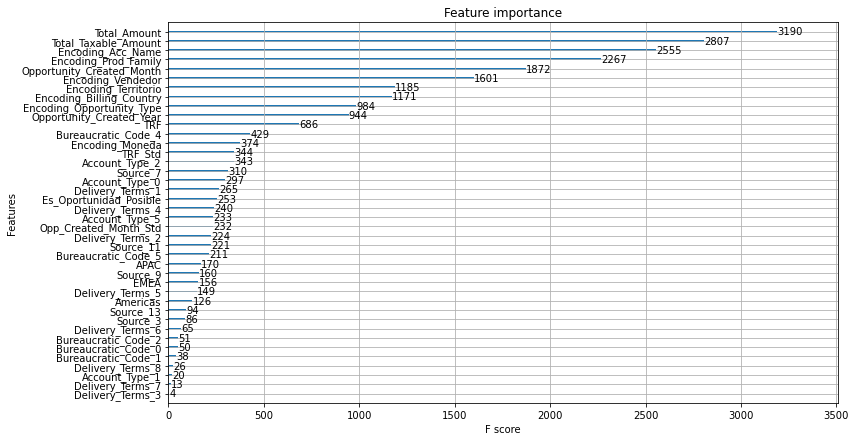

In [348]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

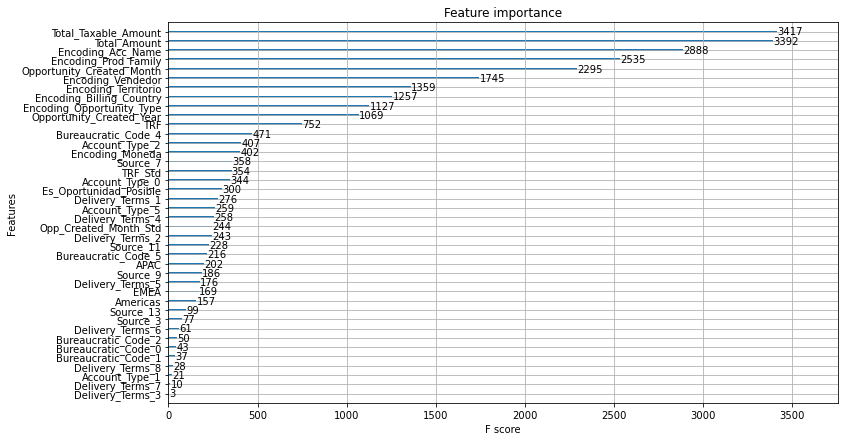

In [349]:
xgb.plot_importance(xg_reg2)